In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

In [2]:
!pip install pytorchvideo transformers evaluate -q

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
!git config --global credential.helper store

In [5]:
# from transformers.utils import send_example_telemetry

# send_example_telemetry("video_classification_notebook", framework="pytorch")

In [6]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

In [7]:
!tar xf {file_path}

In [8]:
dataset_root_path = "ASD_Video"

!find {dataset_root_path} | head -5

'head' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)
print(dataset_root_path)

ASD_Video


In [10]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 22


In [11]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_01.mp4'),
 WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_02.mp4'),
 WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_03.mp4'),
 WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_04.mp4'),
 WindowsPath('ASD_Video/train/Head_banging/Head_banging_01.mp4')]

In [12]:
print(all_video_file_paths)

[WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_01.mp4'), WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_02.mp4'), WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_03.mp4'), WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_04.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_01.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_02.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_03.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_04.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_01.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_02.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_03.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_04.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_05.mp4'), WindowsPath('ASD_Video/val/Arm_flapping/Arm_flapping_05.mp4'), WindowsPath('ASD_Video/val/Arm_flapping/Arm_flapping_06.mp4'), WindowsPath('ASD_Video/val/Head_banging/Head_banging_05.mp4'), Windo

In [13]:

class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})

print(all_video_file_paths)
print(f"Unique classes: {class_labels}.")
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

[WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_01.mp4'), WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_02.mp4'), WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_03.mp4'), WindowsPath('ASD_Video/train/Arm_flapping/Arm_flapping_04.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_01.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_02.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_03.mp4'), WindowsPath('ASD_Video/train/Head_banging/Head_banging_04.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_01.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_02.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_03.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_04.mp4'), WindowsPath('ASD_Video/train/Spinning/Spinning_05.mp4'), WindowsPath('ASD_Video/val/Arm_flapping/Arm_flapping_05.mp4'), WindowsPath('ASD_Video/val/Arm_flapping/Arm_flapping_06.mp4'), WindowsPath('ASD_Video/val/Head_banging/Head_banging_05.mp4'), Windo

In [14]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import pytorchvideo.data


from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [16]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 60
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [17]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(13, 6, 3)

In [18]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [19]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name Arm_flapping_01.mp4
video_index 0
clip_index 0
aug_index 0
label 0
Video label: Arm_flapping


Visualize the preprocessed videos for easier debugging.

In [20]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

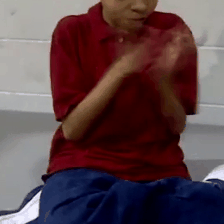

In [21]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

In [22]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-ASD_Behavour_v4"
print(new_model_name)
num_epochs = 10

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)


videomae-base-ASD_Behavour_v4


c:\Users\kanlo\anaconda3\envs\video_classification\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
import evaluate

metric = evaluate.load("accuracy")

In [24]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [25]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [26]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    
)

max_steps is given, it will override any value given in num_train_epochs


In [27]:
train_results = trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\kanlo\anaconda3\envs\video_classification\Lib\site-packages\transformers\models\videomae\modeling_videomae.py:287: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


{'eval_loss': 1.2526744604110718, 'eval_accuracy': 0.21052631578947367, 'eval_runtime': 76.7221, 'eval_samples_per_second': 0.743, 'eval_steps_per_second': 0.104, 'epoch': 0.2}
{'eval_loss': 1.166237711906433, 'eval_accuracy': 0.21052631578947367, 'eval_runtime': 78.9356, 'eval_samples_per_second': 0.722, 'eval_steps_per_second': 0.101, 'epoch': 1.2}
{'eval_loss': 1.183830738067627, 'eval_accuracy': 0.2631578947368421, 'eval_runtime': 74.7456, 'eval_samples_per_second': 0.763, 'eval_steps_per_second': 0.107, 'epoch': 2.2}
{'eval_loss': 1.216902494430542, 'eval_accuracy': 0.24561403508771928, 'eval_runtime': 80.64, 'eval_samples_per_second': 0.707, 'eval_steps_per_second': 0.099, 'epoch': 3.2}
{'loss': 1.0545, 'grad_norm': 8.252554893493652, 'learning_rate': 0.0, 'epoch': 4.2}
{'eval_loss': 1.2212789058685303, 'eval_accuracy': 0.2631578947368421, 'eval_runtime': 71.6783, 'eval_samples_per_second': 0.795, 'eval_steps_per_second': 0.112, 'epoch': 4.2}
{'train_runtime': 481.5995, 'train_sa

In [28]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.1240962743759155,
 'eval_accuracy': 0.14285714285714285,
 'eval_runtime': 16.1199,
 'eval_samples_per_second': 0.868,
 'eval_steps_per_second': 0.124,
 'epoch': 4.2}

In [29]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

events.out.tfevents.1716209982.DESKTOP-SGO0ICV.30040.0:   0%|          | 0.00/7.29k [00:00<?, ?B/s]

events.out.tfevents.1716210508.DESKTOP-SGO0ICV.30040.1:   0%|          | 0.00/405 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

***** test metrics *****
  epoch                   =        4.2
  eval_accuracy           =     0.1429
  eval_loss               =     1.1241
  eval_runtime            = 0:00:16.01
  eval_samples_per_second =      0.874
  eval_steps_per_second   =      0.125


In [30]:
# trainer.push_to_hub()

## Inference

In [31]:
trained_model = VideoMAEForVideoClassification.from_pretrained('videomae-base-ASD_Behavour_v4')

In [32]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name Head_banging.mp4
video_index 1
clip_index 0
aug_index 0
label 1
Video label: Head_banging


In [33]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [34]:
logits = run_inference(trained_model, sample_test_video["video"])

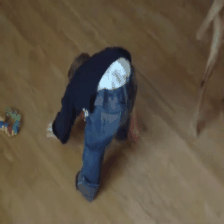

In [35]:
display_gif(sample_test_video["video"])

In [36]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Spinning
